In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
import tqdm
from datetime import datetime
from google.cloud.logging import DESCENDING, Client
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.family'] = 'monospace'

# table 1

builder usage of cancellations. 
1. for a given pubkey, for a given slot, look at submissions
2. order by received at, see how often a lower bid arrives after a higher bid

In [7]:
bids = pd.read_csv("cancellations.csv", delimiter='|')
bids['received_at'] = pd.to_datetime(bids['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
bids.head()

,builder_pubkey,value,received_at,slot
0,0x945fc51bf63613257792926c9155d7ae32db73155dc1...,20125025573932724,2023-04-18 11:23:57.865733,6249418
1,0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4...,20672492160596376,2023-04-18 11:23:57.949259,6249418
2,0x8dde59a0d40b9a77b901fc40bee1116acf643b2b6065...,39436043343241723,2023-04-18 11:23:58.038204,6249418
3,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,22094675931440436,2023-04-18 11:23:58.752694,6249418
4,0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f1...,21671398131636436,2023-04-18 11:23:58.182950,6249418


In [8]:
bids['builder_pubkey'].value_counts()

0x945fc51bf63613257792926c9155d7ae32db73155dc13bdfe61cd476f1fd2297b66601e8721b723cef11e4e6682e9d87    53425
0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4d86ea463d712af1dc80131d0c650dc29ba29ef27c881f43bd587    47041
0xb67eaa5efcfa1d17319c344e1e5167811afbfe7922a2cf01c9a361f465597a5dc3a5472bd98843bac88d2541a78eab08    21913
0x83d3495a2951065cf19c4d282afca0a635a39f6504bd76282ed0138fe28680ec60fa3fd149e6d27a94a7d90e7b1fb640    15219
0xb5a688d26d7858b38c44f44568d68fb94f112fc834cd225d32dc52f0277c2007babc861f6f157a6fc6c1dc25bf409046    12950
0xb194b2b8ec91a71c18f8483825234679299d146495a08db3bf3fb955e1d85a5fca77e88de93a74f4e32320fc922d3027    12343
0x96a59d355b1f65e270b29981dd113625732539e955a1beeecbc471dd0196c4804574ff871d47ed34ff6d921061e9fc27    12041
0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06b7a020304099c23d2d9952d4254cc50f291c385d15e7cae0cf9d    11324
0xb333337fac190c13f152d81c2127b156a2e73ef074f396cf2ac9b1443f6124e57b80267b989095d04c7a2f2e0a3f0bc0    10143
0xa1defa73d675983a6972e86863

In [14]:
slots = sorted(list(set(bids['slot'])))
pks = sorted(list(set(bids['builder_pubkey'])))

In [42]:
pk_subs = {}
pk_cans = {}
for p in pks:
    pk_subs[p] = 0
    pk_cans[p] = 0

In [46]:
for s in tqdm.tqdm(slots):
    for pk in pks:
        builder_subs = bids[(bids['builder_pubkey']==pk) & (bids['slot']==s)].sort_values('received_at')
        if len(builder_subs) == 0:
            continue
        curBid = builder_subs['value'].values[0]
        cancellations = 0
        for v in builder_subs['value']:
            if v < curBid:
                cancellations += 1
                curBid = v
                
        pk_subs[pk] += len(builder_subs)
        pk_cans[pk] += cancellations

100%|██████████| 484/484 [07:33<00:00,  1.07it/s]


In [49]:
for p in pks:
    subs = pk_subs[p]
    cans = pk_cans[p]
    perc = cans / subs
    print("{},{},{},{}".format(p[:9], subs, cans, perc))

0x8000008,5306,4,0.0007538635506973238
0x80c7311,2760,0,0.0
0x81babee,9357,6,0.0006412311638345624
0x81beef0,9554,8,0.0008373456144023446
0x82ba7ca,1071,6,0.0056022408963585435
0x83d3495,15219,93,0.006110782574413562
0x84b02bd,3896,0,0.0
0x8b8edce,3199,2,0.0006251953735542357
0x8bc8d11,9534,101,0.010593664778686805
0x8cb3cb2,4496,0,0.0
0x8d6e6c1,8351,23,0.0027541611783019997
0x8dde59a,6826,83,0.012159390565484911
0x945fc51,53425,112,0.0020963968179691156
0x94a076b,2978,57,0.019140362659503023
0x94aa4ee,3216,2,0.0006218905472636816
0x95c8cc3,2996,34,0.011348464619492658
0x965a05a,2474,68,0.0274858528698464
0x96a59d3,12041,228,0.018935304376712897
0x976e63c,2736,52,0.019005847953216373
0x978a35c,47041,92,0.0019557407368040645
0x984357f,500,7,0.014
0xa00000a,5739,1,0.00017424638438752395
0xa0d0dbd,6348,35,0.005513547574039068
0xa1dead0,9380,7,0.0007462686567164179
0xa1defa7,9706,8,0.00082423243354626
0xa4fb63c,7162,21,0.002932141859815694
0xa66f3ab,5303,2,0.0003771450122572129
0xa971c4e,1

In [50]:
bldrs = pd.read_csv("builders.txt", delimiter='|')
bldrs.head()

,builder_pubkey,builder_id
0,0xb3d48d36bb54c159417d3e87a890ff6bf513b14bdba5...,finest
1,0xab847befe59b5effffa12f47acf44cbf8ef875e7c891...,rickastley
2,0x984357f7e6489e5e04049920bf63087ee6904272e937...,finest
3,0x84b02bdb674a28dea0467d3dded2b4aad11c0c5dba79...,lightspeed
4,0x80c7311597316f871363f8395b6a8d056071d90d8eb2...,bloxroute


In [51]:
buids = sorted(list(set(bldrs['builder_id'])))
buids

['0x69',
 'antbuilder',
 'beaverbuild',
 'blocknative',
 'bloxroute',
 'bob',
 'buildai',
 'finest',
 'flashbots',
 'lightspeed',
 'manta',
 'rickastley',
 'rsync',
 'smithbot',
 'titan']

In [70]:
for b in buids:
    bpks = bldrs[bldrs['builder_id']==b]['builder_pubkey'].values
#     print(b)
    print('\multirow{{3}}{{*}}{{{}}} '.format(b), end='')
    for pk in bpks:
        try:
            subs = pk_subs[pk]
            cans = pk_cans[pk]
            perc = cans / subs
            print('& \\texttt{{{}}} & {} & {} & {:0.3f}\\% \\\\'.format(pk[:9], subs, cans, 100*perc))
        except:
            pass
    print("\\hline")

\multirow{3}{*}{0x69} & \texttt{0xb194b2b} & 12343 & 30 & 0.243\% \\
& \texttt{0xa4fb63c} & 7162 & 21 & 0.293\% \\
& \texttt{0xa971c4e} & 11324 & 78 & 0.689\% \\
& \texttt{0x8bc8d11} & 9534 & 101 & 1.059\% \\
& \texttt{0xb8fceec} & 5604 & 70 & 1.249\% \\
\hline
\multirow{3}{*}{antbuilder} & \texttt{0x8cb3cb2} & 4496 & 0 & 0.000\% \\
& \texttt{0xb066a09} & 5368 & 0 & 0.000\% \\
\hline
\multirow{3}{*}{beaverbuild} & \texttt{0x96a59d3} & 12041 & 228 & 1.894\% \\
& \texttt{0xb5d8835} & 8495 & 57 & 0.671\% \\
& \texttt{0xaec4ec4} & 6584 & 60 & 0.911\% \\
& \texttt{0x8dde59a} & 6826 & 83 & 1.216\% \\
\hline
\multirow{3}{*}{blocknative} & \texttt{0x8000008} & 5306 & 4 & 0.075\% \\
& \texttt{0xa1defa7} & 9706 & 8 & 0.082\% \\
& \texttt{0xa00000a} & 5739 & 1 & 0.017\% \\
& \texttt{0xa66f3ab} & 5303 & 2 & 0.038\% \\
\hline
\multirow{3}{*}{bloxroute} & \texttt{0x80c7311} & 2760 & 0 & 0.000\% \\
& \texttt{0x8b8edce} & 3199 & 2 & 0.063\% \\
& \texttt{0x965a05a} & 2474 & 68 & 2.749\% \\
& \texttt{0x

# table 2

effective cancellations (change the outcome of the auction). 
1. for a given delivered payload, look at submissions for that slot
2. if there is a submission that was eligible at before the submission that ended up winning, and had a higher value. that is an effective cancellation

In [71]:
jnd = pd.read_csv("joinout.txt", delimiter='|')
jnd['eligible_at'] = pd.to_datetime(jnd['eligible_at'], format="%Y-%m-%d%H:%M:%S.%f")
jnd.head()

,winvalue,winpk,slot,winhash,subpk,eligible_at,subhash,subvalue
0,54083681721870963,0x96a59d355b1f65e270b29981dd113625732539e955a1...,6249485,0x80e3e5124e491dd7c39c4ed3a990c02c7ec3107ffafa...,0xaa1488eae4b06a1fff840a2b6db167afc520758dc2c8...,2023-04-18 11:37:13.774753,0x459974a014181b9beafac299108d6bc807cccef3d2b0...,466114509903035
1,61164402763360054,0x96a59d355b1f65e270b29981dd113625732539e955a1...,6249433,0x37fc13caada251487168f98f254bebfcdc8c45c375d4...,0xa66f3abc04df65c16eb32151f2a92cb7921efdba4c25...,2023-04-18 11:26:54.728134,0x550a1cf2b04de5f3b3f2676170ed10a5fd5f7ea7ca4a...,4800572454649876
2,61164402763360054,0x96a59d355b1f65e270b29981dd113625732539e955a1...,6249433,0x37fc13caada251487168f98f254bebfcdc8c45c375d4...,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,2023-04-18 11:26:55.802112,0x86ffc2a5def40ad3ab1c0cc6a2cf9a8b7065725c1618...,16285188269138615
3,61164402763360054,0x96a59d355b1f65e270b29981dd113625732539e955a1...,6249433,0x37fc13caada251487168f98f254bebfcdc8c45c375d4...,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3...,2023-04-18 11:26:51.317402,0x9def387e0ecfe832770a959a44a94fe9f244d683fbb0...,5896797358220104
4,61164402763360054,0x96a59d355b1f65e270b29981dd113625732539e955a1...,6249433,0x37fc13caada251487168f98f254bebfcdc8c45c375d4...,0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f1...,2023-04-18 11:26:55.288501,0xaff22360dee7f29043227c9ec47393ba31eaf65655b8...,16398060530686615


In [72]:
slots = sorted(list(set(jnd['slot'])))

In [137]:
cancelSlots = []
cancelAmts = []
cancelKeys = []
for s in slots:
    subs = jnd[jnd['slot']==s]
    winner = subs[subs['winhash']==subs['subhash']]
    winnerTs = winner['eligible_at'].min()
    effectiveCancels = subs[(subs['subvalue'] > subs['winvalue']) & (subs['eligible_at'] < winnerTs)]
    if len(effectiveCancels) > 0:
        print("{} – {}".format(s, len(effectiveCancels)))
        cancelSlots.append(s)
        cancelAmts.extend((effectiveCancels['subvalue'] - effectiveCancels['winvalue']).values)
        cancelKeys.extend(effectiveCancels['subpk'])
cancelSlots = np.asarray(cancelSlots)
cancelAmts = np.asarray(cancelAmts)

6249473 – 17
6249485 – 1
6249497 – 1
6249524 – 58
6249545 – 3
6249593 – 14
6249599 – 3
6249610 – 3
6249616 – 1
6249626 – 1
6249675 – 7
6249682 – 1
6249685 – 1
6249739 – 2
6249823 – 1
6249830 – 1
6249867 – 8
6249872 – 4
6249906 – 1
6249957 – 2
6249998 – 9
6250051 – 15
6250085 – 1
6250111 – 2
6250163 – 25
6250199 – 57
6250206 – 45
6250216 – 1
6250247 – 8
6250327 – 2
6250361 – 3
6250403 – 6
6250424 – 1
6250466 – 5
6250484 – 2
6250531 – 14
6250562 – 3
6250566 – 1
6250585 – 3
6250641 – 2
6250704 – 12
6250720 – 6


In [237]:
counts = pd.Series(cancelKeys).value_counts()
for k in counts.keys():
    try:
        pksubs = jnd[jnd['winpk']==k]
        pkwins = len(set(pksubs['slot']))
#         print('{}, {}, {}'.format(k[:9], bldrs[bldrs['builder_pubkey']==k]['builder_id'].values[0], counts[k]))
        print('{} & \\texttt{{{}}} & {} & {} \\\\'.format(bldrs[bldrs['builder_pubkey']==k]['builder_id'].values[0], k[:9], counts[k],pkwins))
    except:
        pass

beaverbuild & \texttt{0x96a59d3} & 72 & 115 \\
rsync & \texttt{0x945fc51} & 63 & 23 \\
rsync & \texttt{0x978a35c} & 50 & 15 \\
0x69 & \texttt{0x8bc8d11} & 34 & 67 \\
0x69 & \texttt{0xa971c4e} & 25 & 10 \\
beaverbuild & \texttt{0xb5d8835} & 24 & 19 \\
0x69 & \texttt{0xb194b2b} & 20 & 19 \\
0x69 & \texttt{0xa4fb63c} & 13 & 6 \\
rsync & \texttt{0x83d3495} & 5 & 0 \\
manta & \texttt{0xb5a688d} & 5 & 0 \\
beaverbuild & \texttt{0xaec4ec4} & 4 & 0 \\
titan & \texttt{0xb26f966} & 4 & 0 \\
titan & \texttt{0xb67eaa5} & 3 & 1 \\
flashbots & \texttt{0x81babee} & 3 & 5 \\
manta & \texttt{0xa0d0dbd} & 3 & 1 \\
flashbots & \texttt{0x81beef0} & 3 & 6 \\
beaverbuild & \texttt{0x8dde59a} & 3 & 0 \\
titan & \texttt{0x95c8cc3} & 3 & 1 \\
titan & \texttt{0x94a076b} & 2 & 0 \\
manta & \texttt{0xb1b734b} & 2 & 0 \\
bob & \texttt{0x8d6e6c1} & 2 & 1 \\
0x69 & \texttt{0xb8fceec} & 2 & 1 \\
blocknative & \texttt{0xa66f3ab} & 1 & 1 \\


In [117]:
cancelAmts.mean()

4126228837842309.5

In [101]:
len(slots), len(cancelSlots)

(307, 42)

In [102]:
42/307

0.13680781758957655

In [175]:
subs = jnd[jnd['slot']==6250199]
winner = subs[subs['winhash']==subs['subhash']]
winnerTs = winner['eligible_at'].min()

In [176]:
winnerTs

Timestamp('2023-04-18 14:00:13.514148')

In [199]:
cancels = subs[(subs['subvalue'] > subs['winvalue']) & (subs['eligible_at'] < winnerTs)]
cancels

,winvalue,winpk,slot,winhash,subpk,eligible_at,subhash,subvalue
210468,54028069672660323,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,6250199,0xa94e9edc0bf42fb476d0f5ad02ea557bd40937acb443...,0x96a59d355b1f65e270b29981dd113625732539e955a1...,2023-04-18 14:00:11.812743,0xe2d27e12dbae6aa346480b6c37bb30d9195f689bb60c...,55456578127429778
210595,54028069672660323,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,6250199,0xa94e9edc0bf42fb476d0f5ad02ea557bd40937acb443...,0x96a59d355b1f65e270b29981dd113625732539e955a1...,2023-04-18 14:00:12.626103,0x4129b63d6793fbf17a5829a0c86151063c60ebd03dd5...,60281388407429778
210600,54028069672660323,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,6250199,0xa94e9edc0bf42fb476d0f5ad02ea557bd40937acb443...,0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4...,2023-04-18 14:00:13.082763,0x524ec49659996a944e20fafcbdd701662ee38c698b1e...,58720938514888048
210629,54028069672660323,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,6250199,0xa94e9edc0bf42fb476d0f5ad02ea557bd40937acb443...,0x96a59d355b1f65e270b29981dd113625732539e955a1...,2023-04-18 14:00:11.761462,0x29442061e6689d858ac967e6a2112d02efc27c53fbb1...,55163298727429778
210630,54028069672660323,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,6250199,0xa94e9edc0bf42fb476d0f5ad02ea557bd40937acb443...,0x81babeec8c9f2bb9c329fd8a3b176032fe0ab5f3b92a...,2023-04-18 14:00:12.892439,0xe9a2a3b6b39004c64c9fee2344c6197ab1a889e9ff37...,54235541336427048
210639,54028069672660323,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,6250199,0xa94e9edc0bf42fb476d0f5ad02ea557bd40937acb443...,0x94a076b27f294dc44b9fd44d8e2b063fb129bc85ed04...,2023-04-18 14:00:13.508238,0xad0bff528ffa745f12d6f17ed0c9c987df6801c38ee1...,56278324911010463
210642,54028069672660323,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,6250199,0xa94e9edc0bf42fb476d0f5ad02ea557bd40937acb443...,0xaec4ec48c2ec03c418c599622980184e926f0de3c9ce...,2023-04-18 14:00:13.424736,0xd1d2cf2ee0dba9821138b7e4e1a76fa519aae31b5af6...,57761693216462542
210646,54028069672660323,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,6250199,0xa94e9edc0bf42fb476d0f5ad02ea557bd40937acb443...,0x945fc51bf63613257792926c9155d7ae32db73155dc1...,2023-04-18 14:00:12.754579,0xb1677c06a3415415421ae684fc29ffb07429a14527a7...,54314782091121323
210654,54028069672660323,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,6250199,0xa94e9edc0bf42fb476d0f5ad02ea557bd40937acb443...,0xa4fb63c2ceeee73d1f1711fadf1c5357ac98cecb999d...,2023-04-18 14:00:12.851545,0x72c4df510d975433e5c82d06563eb4f3086a3ab992aa...,55497350036427048
210658,54028069672660323,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,6250199,0xa94e9edc0bf42fb476d0f5ad02ea557bd40937acb443...,0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f1...,2023-04-18 14:00:13.117934,0xd0bc2a1b6d629f85ffa81dfd4367d6e47fb1be75f936...,56414179481739155


In [178]:
set(cancels['subpk'].values)

{'0x81babeec8c9f2bb9c329fd8a3b176032fe0ab5f3b92a3f44d4575a231c7bd9c31d10b6328ef68ed1e8c02a3dbc8e80f9',
 '0x81beef03aafd3dd33ffd7deb337407142c80fea2690e5b3190cfc01bde5753f28982a7857c96172a75a234cb7bcb994f',
 '0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f18c12a6171400eb6e04d49238ba2b0a95e633d15558e6a706fbe4',
 '0x8d6e6c1b552fb5acba2a08eb882008f93f18f0e9c36ff96983778a3c167dd121ced4d214ae5380a9527a8f5ec64e3efd',
 '0x945fc51bf63613257792926c9155d7ae32db73155dc13bdfe61cd476f1fd2297b66601e8721b723cef11e4e6682e9d87',
 '0x94a076b27f294dc44b9fd44d8e2b063fb129bc85ed047da1cefb82d16e1a13e6b50de31a86f5b233d1e6bbaca3c69173',
 '0x95c8cc31f8d4e54eddb0603b8f12d59d466f656f374bde2073e321bdd16082d420e3eef4d62467a7ea6b83818381f742',
 '0x96a59d355b1f65e270b29981dd113625732539e955a1beeecbc471dd0196c4804574ff871d47ed34ff6d921061e9fc27',
 '0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4d86ea463d712af1dc80131d0c650dc29ba29ef27c881f43bd587',
 '0xa4fb63c2ceeee73d1f1711fadf1c5357ac98cecb999d053be613f469a48f7416999a4

In [201]:
winner

,winvalue,winpk,slot,winhash,subpk,eligible_at,subhash,subvalue
212044,54028069672660323,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,6250199,0xa94e9edc0bf42fb476d0f5ad02ea557bd40937acb443...,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e...,2023-04-18 14:00:13.514148,0xa94e9edc0bf42fb476d0f5ad02ea557bd40937acb443...,54028069672660323


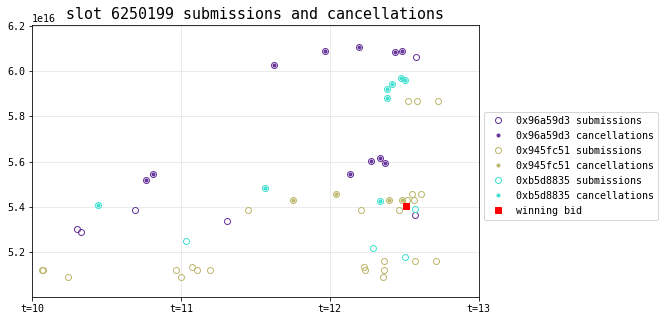

In [235]:
f, ax = plt.subplots(figsize=(8,5))

j = 0
colors = ['rebeccapurple', 'darkkhaki', 'turquoise']
for i, pk in enumerate(set(cancels['subpk'].values)):
    if i in [5, 3, 7]:
        subcs = cancels[cancels['subpk']==pk].sort_values('eligible_at')
        subspk = subs[subs['subpk']==pk].sort_values('eligible_at')
        ax.plot(subspk['eligible_at'], subspk['subvalue'], color=colors[j], marker='o', fillstyle='none',linestyle='none',
                label='{} submissions'.format(pk[:9]))
        ax.plot(subcs['eligible_at'], subcs['subvalue'], color=colors[j], marker='.', linestyle='none',
               label='{} cancellations'.format(pk[:9]))
        j+=1
    

ax.plot(winner['eligible_at'], winner['winvalue'], marker='s', color='r', label='winning bid', linestyle='none')
ax.set_ylim(50028069672660323, 62028069672660323)
ax.set_xlim('2023-04-18 14:00:11.', '2023-04-18 14:00:14.')
ax.set_xticks(['2023-04-18 14:00:11.', '2023-04-18 14:00:12.', '2023-04-18 14:00:13.', '2023-04-18 14:00:14.'])
ax.set_xticklabels(['t=10', 't=11', 't=12', 't=13'])

ax.set_title('slot 6250199 submissions and cancellations', size=15)
ax.legend(bbox_to_anchor=(1,0.7))
plt.show()

In [112]:
(cancels['subvalue'] - cancels['winvalue']).mean()

1121472112395009.0

## table 3 full week full builders

In [123]:
jnd = pd.read_csv("fullweek.csv", delimiter='|', names=['winvalue', 'winpk','slot','winhash','subpk','eligible_at','subhash','subvalue'])
jnd['eligible_at'] = pd.to_datetime(jnd['eligible_at'], format="%Y-%m-%d%H:%M:%S.%f")
jnd.head()

,winvalue,winpk,slot,winhash,subpk,eligible_at,subhash,subvalue
0,26142799992836613,0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f1...,6245317,0xbd6b590606cad85ae365f4c524de301ccbf819b519a9...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,2023-04-17 21:43:43.743224,0x0bad471d3c3f245b0d8afc922199387389c023cef770...,22416669944633376
1,26142799992836613,0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f1...,6245317,0xbd6b590606cad85ae365f4c524de301ccbf819b519a9...,0xa82f9afce834eeb0e6d9aa5bb99d2d87a2ba6d97f6f7...,2023-04-17 21:43:43.418433,0x71ab9f77b07598565fca0fdb73954039250740c64e5a...,11032921836225402
2,192363022357633736,0x96a59d355b1f65e270b29981dd113625732539e955a1...,6245045,0x8af9ef1cb7a1a708a25efd5b75e18911bb931dac3f6e...,0xaa1488eae4b06a1fff840a2b6db167afc520758dc2c8...,2023-04-17 20:49:19.153411,0x98af853c4593c8cc9b00f12af8a1dd00ac5785ba99e9...,56891666347471290
3,26142799992836613,0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f1...,6245317,0xbd6b590606cad85ae365f4c524de301ccbf819b519a9...,0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4...,2023-04-17 21:43:43.855322,0xe593814464216e14fed21b9d8c1580d6abd6ede39ffc...,19022757629706031
4,192363022357633736,0x96a59d355b1f65e270b29981dd113625732539e955a1...,6245045,0x8af9ef1cb7a1a708a25efd5b75e18911bb931dac3f6e...,0xb333337fac190c13f152d81c2127b156a2e73ef074f3...,2023-04-17 20:49:13.931199,0x97ed098d750cb0218c909b8f7283c85e74c81e357b7a...,39497519186503859


In [124]:
slots = sorted(list(set(jnd['slot'])))
len(slots)

1979

In [125]:
cancelSlots = []
cancelAmts = []
cancelKeys = []
for s in slots:
    subs = jnd[jnd['slot']==s]
    winner = subs[subs['winhash']==subs['subhash']]
    winnerTs = winner['eligible_at'].min()
    effectiveCancels = subs[(subs['subvalue'] > subs['winvalue']) & (subs['eligible_at'] < winnerTs)]
    if len(effectiveCancels) > 0:
        print("{} – {}".format(s, len(effectiveCancels)))
        cancelSlots.append(s)
        cancelAmts.extend((effectiveCancels['subvalue'] - effectiveCancels['winvalue']).values)
        cancelKeys.extend(effectiveCancels['subpk'])
cancelSlots = np.asarray(cancelSlots)
cancelAmts = np.asarray(cancelAmts)

6245062 – 3
6245066 – 1
6245076 – 4
6245079 – 1
6245091 – 2
6245179 – 1
6245205 – 1
6245223 – 3
6245225 – 7
6245234 – 1
6245271 – 3
6245284 – 2
6245287 – 21
6245338 – 1
6245345 – 1
6245428 – 1
6245442 – 3
6245480 – 1
6245484 – 1
6245564 – 2
6245569 – 3
6245605 – 3
6245613 – 12
6245642 – 1
6245690 – 2
6245693 – 2
6245701 – 1
6245704 – 1
6245731 – 7
6245740 – 5
6245747 – 1
6245779 – 1
6245790 – 2
6245803 – 2
6245813 – 3
6245839 – 2
6245897 – 1
6245902 – 1
6246026 – 5
6246089 – 4
6246096 – 1
6246125 – 2
6246154 – 1
6246189 – 1
6246224 – 6
6246251 – 1
6246274 – 43
6246277 – 7
6246290 – 2
6246317 – 3
6246373 – 1
6246380 – 13
6246403 – 2
6246443 – 1
6246456 – 1
6246462 – 2
6246504 – 1
6246507 – 1
6246538 – 1
6246552 – 1
6246585 – 1
6246593 – 1
6246616 – 19
6246666 – 1
6246705 – 11
6246766 – 1
6246787 – 12
6246848 – 5
6246862 – 5
6246877 – 1
6246898 – 5
6246905 – 4
6246978 – 11
6246984 – 2
6247075 – 14
6247086 – 8
6247160 – 1
6247181 – 1
6247209 – 1
6247285 – 2
6247287 – 1
6247328 – 4
6247376

In [126]:
bldrs = pd.read_csv("buildersfull.csv", delimiter='|')
bldrs.head()

,builder_pubkey,builder_id,description
0,0xb3d48d36bb54c159417d3e87a890ff6bf513b14bdba5...,finest,finest
1,0x83bee51799e65130296f5d60ce7d78119578db6045c3...,emptystring1,emptystring1
2,0xab847befe59b5effffa12f47acf44cbf8ef875e7c891...,rickastley,rickastley
3,0x8ef6185b16ab8fe018ba98c9f514522a60e437be0e8d...,NaN,eth
4,0x984357f7e6489e5e04049920bf63087ee6904272e937...,finest,finest


In [127]:
counts = pd.Series(cancelKeys).value_counts()
total_wins = 0
for k in counts.keys():
    pksubs = jnd[jnd['winpk']==k]
    pkwins = len(set(pksubs['slot']))
    print('{} & \\texttt{{{}}} & {} & {} \\\\'.format(
        bldrs[bldrs['builder_pubkey']==k]['builder_id'].values[0], k[:9], counts[k], pkwins))
    total_wins += pkwins

beaverbuild & \texttt{0x96a59d3} & 287 & 585 \\
rsync & \texttt{0x945fc51} & 242 & 165 \\
0x69 & \texttt{0x8bc8d11} & 140 & 465 \\
rsync & \texttt{0x978a35c} & 109 & 52 \\
0x69 & \texttt{0xa971c4e} & 95 & 84 \\
0x69 & \texttt{0xb194b2b} & 70 & 189 \\
beaverbuild & \texttt{0xb5d8835} & 64 & 168 \\
0x69 & \texttt{0xa4fb63c} & 43 & 66 \\
nan & \texttt{0x8e6df6e} & 25 & 18 \\
0x69 & \texttt{0xb8fceec} & 19 & 19 \\
flashbots & \texttt{0x81babee} & 11 & 50 \\
flashbots & \texttt{0x81beef0} & 11 & 24 \\
manta & \texttt{0xb5a688d} & 11 & 2 \\
titan & \texttt{0xb67eaa5} & 11 & 7 \\
flashbots & \texttt{0xa1dead0} & 10 & 26 \\
manta & \texttt{0xb1b734b} & 8 & 0 \\
manta & \texttt{0xa0d0dbd} & 7 & 1 \\
rsync & \texttt{0x83d3495} & 5 & 0 \\
titan & \texttt{0xb26f966} & 4 & 1 \\
beaverbuild & \texttt{0xaec4ec4} & 4 & 1 \\
beaverbuild & \texttt{0x8dde59a} & 3 & 1 \\
titan & \texttt{0x95c8cc3} & 3 & 3 \\
titan & \texttt{0x94a076b} & 2 & 2 \\
bob & \texttt{0x8d6e6c1} & 2 & 1 \\
payload & \texttt{0x8955

In [128]:
total_wins

1948

In [130]:
cancelAmts.max()

77957030196131134

In [265]:
len(cancelAmts)

1195

In [260]:
len(slots), len(cancelSlots)

(1979, 242)

In [261]:
242/1979

0.12228398180899444

# single slot examination 

In [254]:
subs = jnd[jnd['slot']==6245287]
winner = subs[subs['winhash']==subs['subhash']]
winnerTs = winner['eligible_at'].min()

In [256]:
winner

,winvalue,winpk,slot,winhash,subpk,eligible_at,subhash,subvalue
146432,125119775208405936,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,6245287,0xfd93578db028bfddee38ff9f26f13471c8fd8825aea6...,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,2023-04-17 21:37:47.977318,0xfd93578db028bfddee38ff9f26f13471c8fd8825aea6...,125119775208405936


In [257]:
cancels = subs[(subs['subvalue'] > subs['winvalue']) & (subs['eligible_at'] < winnerTs)]
cancels

,winvalue,winpk,slot,winhash,subpk,eligible_at,subhash,subvalue
142532,125119775208405936,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,6245287,0xfd93578db028bfddee38ff9f26f13471c8fd8825aea6...,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,2023-04-17 21:37:47.631129,0x785abfa199a8285810a1429ea63a6322c69e61366489...,125171805775813208
142546,125119775208405936,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,6245287,0xfd93578db028bfddee38ff9f26f13471c8fd8825aea6...,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,2023-04-17 21:37:47.560639,0x45ac2fd662087152f9dd28edc23931a85ea50c8a8c17...,125262188175813208
145954,125119775208405936,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,6245287,0xfd93578db028bfddee38ff9f26f13471c8fd8825aea6...,0x96a59d355b1f65e270b29981dd113625732539e955a1...,2023-04-17 21:37:47.601270,0x6b501ef2a22d993d47d616f3c867108a3349be80c7e1...,125728416043324774
146005,125119775208405936,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,6245287,0xfd93578db028bfddee38ff9f26f13471c8fd8825aea6...,0x96a59d355b1f65e270b29981dd113625732539e955a1...,2023-04-17 21:37:47.818115,0xc2e21cde674839b9216822ed9da626fa3ddc611cc970...,125605187343324774
146021,125119775208405936,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,6245287,0xfd93578db028bfddee38ff9f26f13471c8fd8825aea6...,0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f1...,2023-04-17 21:37:47.636124,0x4895bf4867904a01eb744e3cf3a1c019086491f25d3e...,125838934772049208
146027,125119775208405936,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,6245287,0xfd93578db028bfddee38ff9f26f13471c8fd8825aea6...,0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f1...,2023-04-17 21:37:47.908278,0x34f9f458a18db8cbbd3ddc64e65fc06fbc14550fcd8c...,125894161584489208
146028,125119775208405936,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,6245287,0xfd93578db028bfddee38ff9f26f13471c8fd8825aea6...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,2023-04-17 21:37:47.338134,0x8176114507741b51ebe53287e38949230272532ab22d...,125243676175813208
146039,125119775208405936,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,6245287,0xfd93578db028bfddee38ff9f26f13471c8fd8825aea6...,0x96a59d355b1f65e270b29981dd113625732539e955a1...,2023-04-17 21:37:47.914806,0x06f8ece5a2bde6155c286b13a6a541995063aee99df1...,125932868555714774
146055,125119775208405936,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,6245287,0xfd93578db028bfddee38ff9f26f13471c8fd8825aea6...,0xa4fb63c2ceeee73d1f1711fadf1c5357ac98cecb999d...,2023-04-17 21:37:47.427147,0x2f0adce0e844124caac721808aad24dbd270713bc60f...,125243676175813208
146084,125119775208405936,0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06...,6245287,0xfd93578db028bfddee38ff9f26f13471c8fd8825aea6...,0x96a59d355b1f65e270b29981dd113625732539e955a1...,2023-04-17 21:37:47.615674,0x34a83cf8155cec658b473913640fca1f5f1fc0c6ab55...,125582460443324774


## flashbots

In [267]:
jnd = pd.read_csv("flashbots.csv", names=['winvalue', 'winpk','slot','winhash','subpk','eligible_at','subhash','subvalue'])
jnd['eligible_at'] = pd.to_datetime(jnd['eligible_at'], format="%Y-%m-%d %H:%M:%S.%f")
jnd.head()

,winvalue,winpk,slot,winhash,subpk,eligible_at,subhash,subvalue
0,182846493771780299,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,6252547,0x372a43e0b3ff8c40ae67a9507d8fedf0a6e3b5a83bba...,0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4...,2023-04-18 21:49:48.475680,0x5fc903c077b8f7d015641a41a4255fd87001ad656cbe...,140868491391106209
1,358203240285892149,0x945fc51bf63613257792926c9155d7ae32db73155dc1...,6252512,0x72e8e1cde7bff9214db3bf31281f88637edd0305f71f...,0x8ecd091acecda7907aefa2a86253de9e4b4ba3d1d69b...,2023-04-18 21:42:39.785204,0x9723f65a41a05aea2de7d32521c6ebf1da9752bee013...,15945588017861842
2,182846493771780299,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,6252547,0x372a43e0b3ff8c40ae67a9507d8fedf0a6e3b5a83bba...,0xaec4ec48c2ec03c418c599622980184e926f0de3c9ce...,2023-04-18 21:49:49.368614,0x4baba2d650be6004a68dd1ab8d2a3918cb4877bf9c0a...,32974687022964054
3,182846493771780299,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,6252547,0x372a43e0b3ff8c40ae67a9507d8fedf0a6e3b5a83bba...,0x945fc51bf63613257792926c9155d7ae32db73155dc1...,2023-04-18 21:49:49.387735,0x488a0aa43754ee4c1e44ad78dfc12a3b98a485550574...,180608259967953596
4,182846493771780299,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,6252547,0x372a43e0b3ff8c40ae67a9507d8fedf0a6e3b5a83bba...,0x83d3495a2951065cf19c4d282afca0a635a39f6504bd...,2023-04-18 21:49:46.703836,0x4c6d5279cf5052fd21a7b47d42a6cd405ebce8270173...,34861128846418337


In [268]:
slots = sorted(list(set(jnd['slot'])))
len(slots)

914

In [269]:
cancelSlots = []
cancelAmts = []
cancelKeys = []
for s in slots:
    subs = jnd[jnd['slot']==s]
    winner = subs[subs['winhash']==subs['subhash']]
    winnerTs = winner['eligible_at'].min()
    effectiveCancels = subs[(subs['subvalue'] > subs['winvalue']) & (subs['eligible_at'] < winnerTs)]
    if len(effectiveCancels) > 0:
        print("{} – {}".format(s, len(effectiveCancels)))
        cancelSlots.append(s)
        cancelAmts.extend((effectiveCancels['subvalue'] - effectiveCancels['winvalue']).values)
        cancelKeys.extend(effectiveCancels['subpk'])
cancelSlots = np.asarray(cancelSlots)
cancelAmts = np.asarray(cancelAmts)

6252512 – 2
6252518 – 1
6252532 – 4
6252534 – 5
6252547 – 1
6252594 – 21
6252599 – 4
6252605 – 3
6252610 – 3
6252629 – 1
6252693 – 3
6252696 – 2
6252740 – 2
6252778 – 1
6252794 – 1
6252797 – 2
6252799 – 1
6252819 – 2
6252842 – 2
6252848 – 2
6252851 – 2
6252887 – 1
6252935 – 1
6252949 – 4
6252975 – 4
6253016 – 6
6253019 – 2
6253023 – 1
6253031 – 3
6253036 – 3
6253046 – 5
6253082 – 14
6253110 – 3
6253177 – 1
6253203 – 1
6253207 – 2
6253245 – 3
6253247 – 1
6253266 – 4
6253344 – 1
6253350 – 3
6253397 – 2
6253398 – 1
6253422 – 1
6253430 – 4
6253471 – 1
6253496 – 3
6253513 – 3
6253514 – 1
6253546 – 1
6253570 – 22
6253614 – 1
6253618 – 1
6253635 – 3
6253658 – 6
6253663 – 1
6253688 – 1
6253775 – 1
6253785 – 1
6253801 – 6
6253821 – 4
6253871 – 1
6253916 – 3
6253967 – 1
6253987 – 1
6254026 – 3
6254055 – 2
6254072 – 3
6254120 – 8
6254201 – 10
6254290 – 1
6254297 – 1
6254298 – 9
6254313 – 1
6254326 – 4
6254369 – 2
6254373 – 1
6254396 – 1
6254414 – 1
6254428 – 1
6254435 – 1
6254457 – 1
6254487 – 4


In [270]:
bldrs = pd.read_csv("buildersfull.csv", delimiter='|')
bldrs.head()

,builder_pubkey,builder_id,description
0,0xb3d48d36bb54c159417d3e87a890ff6bf513b14bdba5...,finest,finest
1,0x83bee51799e65130296f5d60ce7d78119578db6045c3...,emptystring1,emptystring1
2,0xab847befe59b5effffa12f47acf44cbf8ef875e7c891...,rickastley,rickastley
3,0x8ef6185b16ab8fe018ba98c9f514522a60e437be0e8d...,NaN,eth
4,0x984357f7e6489e5e04049920bf63087ee6904272e937...,finest,finest


In [273]:
counts = pd.Series(cancelKeys).value_counts()
total_wins = 0
for k in counts.keys():
    try:
        buid = bldrs[bldrs['builder_pubkey']==k]['builder_id'].values[0]
    except:
        buid = "UNKNOWN"
    pksubs = jnd[jnd['winpk']==k]
    pkwins = len(set(pksubs['slot']))
    print('{} & \\texttt{{{}}} & {} & {} \\\\'.format(buid, k[:9], counts[k], pkwins))
    total_wins += pkwins

rsync & \texttt{0x945fc51} & 162 & 112 \\
rsync & \texttt{0x978a35c} & 58 & 34 \\
beaverbuild & \texttt{0xb5d8835} & 57 & 91 \\
0x69 & \texttt{0xb8fceec} & 42 & 74 \\
0x69 & \texttt{0xa4fb63c} & 41 & 88 \\
0x69 & \texttt{0xb194b2b} & 36 & 90 \\
0x69 & \texttt{0xa971c4e} & 31 & 43 \\
beaverbuild & \texttt{0x96a59d3} & 26 & 46 \\
flashbots & \texttt{0x81babee} & 21 & 101 \\
flashbots & \texttt{0xa1dead0} & 19 & 58 \\
flashbots & \texttt{0x81beef0} & 18 & 72 \\
payload & \texttt{0x89551cb} & 7 & 11 \\
bob & \texttt{0x8c344fe} & 4 & 1 \\
bob & \texttt{0x8d6e6c1} & 3 & 1 \\
eth & \texttt{0x8ed7489} & 3 & 30 \\
bob & \texttt{0xa31892c} & 3 & 1 \\
bloxroute & \texttt{0x8b8edce} & 2 & 1 \\
UNKNOWN & \texttt{0xa9068c4} & 2 & 2 \\
bob & \texttt{0x91afe26} & 1 & 3 \\
UNKNOWN & \texttt{0xacd6630} & 1 & 0 \\
nfactorial & \texttt{0xa82f9af} & 1 & 0 \\
lightspeed & \texttt{0xb3a4b13} & 1 & 0 \\
beaverbuild & \texttt{0x8dde59a} & 1 & 0 \\
buildai & \texttt{0x82ba7ca} & 1 & 15 \\
blocknative & \texttt{

In [274]:
total_wins

876

In [279]:
int(cancelAmts.mean())

16591601413502676

In [280]:
[(int(i*100), np.quantile(cancelAmts, i)) for i in [.50, .90, .99]]

[(50, 2911917120812608.0),
 (90, 1.9940115140791096e+16),
 (99, 8.707936965110918e+16)]

In [276]:
len(cancelAmts)

545

In [278]:
len(slots), len(cancelSlots), len(cancelSlots) / len(slots)

(914, 148, 0.16192560175054704)

# ineffective cancellations

1. for each payload delivered get the value, eligible at, and builder_pubkey of the submission
2. if there are submissions from the same builder that have eligible at after the winning block but before the start of the slot, and have value less than the winning block then those are ignored cancellations.  

In [14]:
jnd = pd.read_csv("fullweek.csv", delimiter='|', names=['winvalue', 'winpk','slot','winhash','subpk','eligible_at','subhash','subvalue'])
jnd['eligible_at'] = pd.to_datetime(jnd['eligible_at'], format="%Y-%m-%d%H:%M:%S.%f")
jnd['boundary'] = pd.to_datetime(1606824023 + jnd['slot'] * 12, unit='s')
jnd.head()

,winvalue,winpk,slot,winhash,subpk,eligible_at,subhash,subvalue,boundary
0,26142799992836613,0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f1...,6245317,0xbd6b590606cad85ae365f4c524de301ccbf819b519a9...,0xb194b2b8ec91a71c18f8483825234679299d146495a0...,2023-04-17 21:43:43.743224,0x0bad471d3c3f245b0d8afc922199387389c023cef770...,22416669944633376,2023-04-17 21:43:47
1,26142799992836613,0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f1...,6245317,0xbd6b590606cad85ae365f4c524de301ccbf819b519a9...,0xa82f9afce834eeb0e6d9aa5bb99d2d87a2ba6d97f6f7...,2023-04-17 21:43:43.418433,0x71ab9f77b07598565fca0fdb73954039250740c64e5a...,11032921836225402,2023-04-17 21:43:47
2,192363022357633736,0x96a59d355b1f65e270b29981dd113625732539e955a1...,6245045,0x8af9ef1cb7a1a708a25efd5b75e18911bb931dac3f6e...,0xaa1488eae4b06a1fff840a2b6db167afc520758dc2c8...,2023-04-17 20:49:19.153411,0x98af853c4593c8cc9b00f12af8a1dd00ac5785ba99e9...,56891666347471290,2023-04-17 20:49:23
3,26142799992836613,0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f1...,6245317,0xbd6b590606cad85ae365f4c524de301ccbf819b519a9...,0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4...,2023-04-17 21:43:43.855322,0xe593814464216e14fed21b9d8c1580d6abd6ede39ffc...,19022757629706031,2023-04-17 21:43:47
4,192363022357633736,0x96a59d355b1f65e270b29981dd113625732539e955a1...,6245045,0x8af9ef1cb7a1a708a25efd5b75e18911bb931dac3f6e...,0xb333337fac190c13f152d81c2127b156a2e73ef074f3...,2023-04-17 20:49:13.931199,0x97ed098d750cb0218c909b8f7283c85e74c81e357b7a...,39497519186503859,2023-04-17 20:49:23


In [33]:
(jnd['boundary'] - jnd['eligible_at']).mean().total_seconds()

1.33429

In [10]:
slots = sorted(list(set(jnd['slot'])))
len(slots)

1979

In [60]:
ncSlots = []
ncKeys = []
for s in slots:
    subs = jnd[jnd['slot']==s]
    winner = subs[subs['winhash']==subs['subhash']]
    if len(winner) == 0:
        continue

    winnerTs = winner['eligible_at'].max()
    wv = list(set(winner['winvalue'].values))
    assert(len(wv)==1)
    winnerVal = wv[0]
    wp = list(set(winner['winpk'].values))
    assert(len(wp)==1)
    winnerPk = wp[0]
    
    subs = subs[subs['subpk']==winnerPk]
    
    cancelAttempts = subs[
        (subs['subvalue'] < winnerVal) & 
        (subs['eligible_at'] > winnerTs) &
        (subs['eligible_at'] < subs['boundary'])
    ]
    
    if len(cancelAttempts) > 0:
        print("{} – {}".format(s, len(cancelAttempts)))
        ncSlots.append(s)
        ncKeys.extend(cancelAttempts['subpk'])
ncSlots = np.asarray(ncSlots)

6245170 – 1
6245278 – 1
6246504 – 1
6246868 – 1
6246959 – 1
6247875 – 1
6248369 – 1
6250322 – 1
6250337 – 1
6251646 – 1
6251862 – 1
6251956 – 1


# single slot examination 

In [117]:
subs = jnd[jnd['slot']==6251646]
winner = subs[subs['winhash']==subs['subhash']]
winnerTs = winner['eligible_at'].max()

In [118]:
winner

,winvalue,winpk,slot,winhash,subpk,eligible_at,subhash,subvalue,boundary
1625816,188616215923754408,0x96a59d355b1f65e270b29981dd113625732539e955a1...,6251646,0x5cb19f488814a8d8db9bf9dd86d721e954c04266f453...,0x96a59d355b1f65e270b29981dd113625732539e955a1...,2023-04-18 18:49:34.758347,0x5cb19f488814a8d8db9bf9dd86d721e954c04266f453...,188616215923754408,2023-04-18 18:49:35


In [119]:
winnerPk = winner['subpk'].values[0]
winnerPk

'0x96a59d355b1f65e270b29981dd113625732539e955a1beeecbc471dd0196c4804574ff871d47ed34ff6d921061e9fc27'

In [120]:
winnerTs

Timestamp('2023-04-18 18:49:34.758347')

In [121]:
subs = subs[subs['subpk']==winnerPk]
    
cancelAttempts = subs[
    (subs['subvalue'] < winnerVal) & 
    (subs['eligible_at'] > winnerTs) &
    (subs['eligible_at'] < subs['boundary'])
]

In [122]:
cancelAttempts

,winvalue,winpk,slot,winhash,subpk,eligible_at,subhash,subvalue,boundary
1625828,188616215923754408,0x96a59d355b1f65e270b29981dd113625732539e955a1...,6251646,0x5cb19f488814a8d8db9bf9dd86d721e954c04266f453...,0x96a59d355b1f65e270b29981dd113625732539e955a1...,2023-04-18 18:49:34.847948,0xdd07fd98edbd650934911cca776e1aa6bee26a06da45...,178453322834809887,2023-04-18 18:49:35


In [58]:
subs = subs[subs['subpk']==winnerPk]

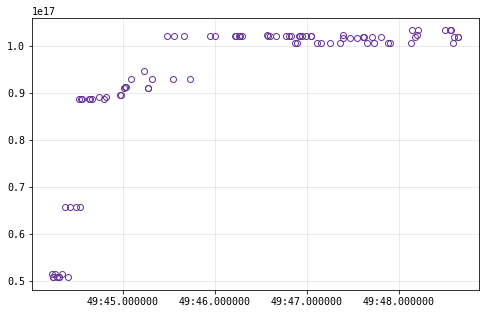

In [59]:
f, ax = plt.subplots(figsize=(8,5))

ax.plot(subs['eligible_at'], subs['subvalue'], color='rebeccapurple', marker='o', fillstyle='none',linestyle='none')
    

# ax.plot(winner['eligible_at'], winner['winvalue'], marker='s', color='r', label='winning bid', linestyle='none')
# ax.set_ylim(50028069672660323, 62028069672660323)
# ax.set_xlim('2023-04-18 14:00:11.', '2023-04-18 14:00:14.')
# ax.set_xticks(['2023-04-18 14:00:11.', '2023-04-18 14:00:12.', '2023-04-18 14:00:13.', '2023-04-18 14:00:14.'])
# ax.set_xticklabels(['t=10', 't=11', 't=12', 't=13'])

# ax.set_title('slot 6250199 submissions and cancellations', size=15)
# ax.legend(bbox_to_anchor=(1,0.7))
plt.show()